In [18]:
# Signal Preprocessing Methods
from preprocessModule import *

# Transform preprocessed signal into an input formation
from transformModule import *

# Plot methods for various input data
from plotModule import *

# Channel information
from meta_data import * 

In [4]:
import pickle

import argparse
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import keyboard

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations

In [6]:
# setting
sf =  250 #board.get_sampling_rate(0)
eeg_channels = BoardShim.get_eeg_channels(BoardIds.CYTON_BOARD.value)
n_sec = 3
n_ch = 8

# 1-1. Get Data from Cyton Board

* (For cyton board) specify below
    * board_id : 0
    * serial_port field of BrainFlowInputParams structure

* Cyton board spec
    * 8 eeg channels
    * 3 acceleration channels
    * sampling rate : 250
    * communication : serial port
    * signal gain : 24


In [5]:
def set_board():
    params = BrainFlowInputParams()
    params.serial_port = 'COM8'
    BoardShim.enable_dev_board_logger()
    return BoardShim(0, params)

def start_record(board):
    board.prepare_session()
    # while not board.is_prepared():
    board.start_stream()
    
def stop_record(board):
    board.stop_stream()
    board.release_session()
    
def rail_test(signal):
    railed_channels = []
    for ch in range(0, n_ch):
        val1,val2,val3 = signal[ch][1:4]

        if val1 == val2 and val2 == val3:
            is_railed[ch] = True
            railed_channels.append(ch+1)
        else: is_railed[ch] = False;
    return railed_channels

In [40]:
# railed channels
is_railed = [{x:0} for x in range(0, n_ch)]
threshold_railed = int(pow(2,23)-1000) #fully railed should be +/- 2^23
threshold_railed_warn = int(pow(2,23) * 0.75)

splitted_signal = []

# main
board = set_board() 
start_record(board)

while True:
    if keyboard.is_pressed('q'):
        print("종료")
        break
    time.sleep(n_sec)
    
    temp_signal = board.get_current_board_data(n_sec * sf) # latest data from a board 
    temp_signal = temp_signal[eeg_channels, :]
    
    railed_channels = rail_test(temp_signal)
    if len(railed_channels) != 0:
        print("Railed Channels = ", railed_channels)
        continue # do not saved railed signals
    splitted_signal.append(temp_signal)

# whole signal (Warn : could contain railed signals)
total_signal = board.get_board_data() # get all data and remove it from internal buffer
total_signal = total_signal[eeg_channels, :]

stop_record(board)
print("정상적으로 종료 되었습니다.")

중간 signal 저장
Railed_channels : 
중간 signal 저장
Railed_channels : 
중간 signal 저장
Railed_channels : 


KeyboardInterrupt: 

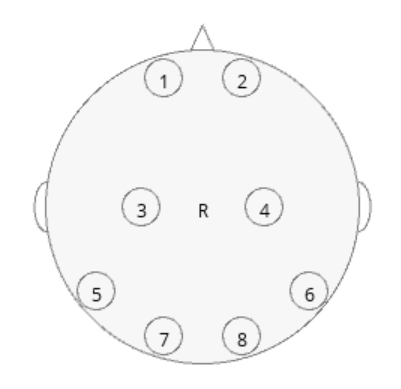

In [41]:
# stop_record(board)

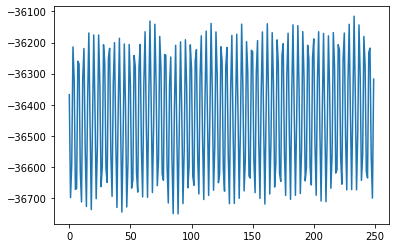

In [50]:
plt.plot(temp_signal[0][:sf])

### Save

In [3]:
with open('test_eeg.pickle', 'wb') as f:
    pickle.dump(total_signal, f, pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: 'test_eeg.pickle'

### Load
#### Load brainflow data

In [10]:
# load brainflow data
with open('test_eeg.pickle', 'rb') as f:
    total_signal = pickle.load(f)
    total_signal = total_signal[eeg_channels, :]
    print(total_signal.shape)

(8, 2364)


#### Load openBCI-GUI data

In [161]:
# load openBCI-GUI data
# openguiPath = "C:/Users/nelum/Documents/OpenBCI_GUI/Recordings/연지/ㅁㅊ개무서워.txt"
# openguiPath = "C:/Users/nelum/Documents/OpenBCI_GUI/Recordings/연지/슬픔1.txt"
openguiPath = "C:/Users/nelum/Documents/OpenBCI_GUI/Recordings/연지/폭포(neutral).txt"
# openguiPath = "C:/Users/nelum/Documents/OpenBCI_GUI/Recordings/연지/침착맨(Happy).txt"


total_signal = []

f = open(openguiPath,'r')

while True:
    line = f.readline()
    if not line: break
    if line[0] == "%": continue
    values = [float(val.strip(',')) for val in line.split()[1:9]] 
    total_signal.append(values)
    
total_signal = np.array(total_signal)
totalTime = len(total_signal)//sf
print("신호의 길이 : ", totalTime, "sec")

total_signal = total_signal[1:sf*totalTime+1] # 첫 측정 제외, 256 단위로 자르기
total_signal = np.transpose(total_signal)

print(total_signal.shape)

f.close()

신호의 길이 :  102 sec
(8, 25500)


# 2. plot original signal

(8, 25500)


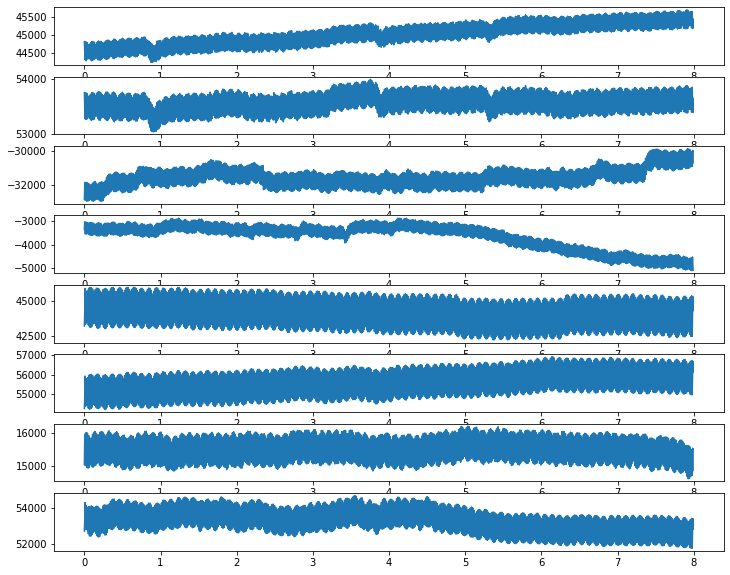

In [162]:
print(total_signal.shape)

# range to plot
st = 1 # brainflow는 초반 1초 제거해야함.
en = sf*8
time = np.arange(len(total_signal[0, st:en]))/sf

plt.figure(figsize=(12,10))

eeg_channels = BoardShim.get_eeg_channels(BoardIds.CYTON_BOARD.value) # 0  
for ch in eeg_channels:
    plt.subplot(810+ch)
    plt.plot(time, total_signal[ch-1, st:en])

# 3. Input representation

In [163]:
freqs = [freq for freq in range(4,46,1)]
chosen_channels = [i for i in range(0, n_ch)]

chunk_size = 10 * sf
overlap = 5 * sf

fftMap_list = []

sig_len = total_signal.shape[1]//sf
all_chunks = [total_signal[:, start:start+chunk_size] 
            for start in range(0, sf*sig_len - chunk_size + 1, chunk_size-overlap)]

for chunk in all_chunks:
    fftMap = computefftMap(chunk, chosen_channels, freqs, sf)
    fftMap_list.append(fftMap)

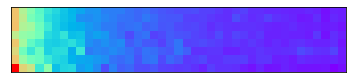

In [164]:
show_image(fftMap_list[10])

## Test trained model

In [67]:
import torch.nn as nn
import torch.nn.functional as F

lin_len = 592 #(채널 8)
out_len = 3
n_channel = 1
model_type = "cla"

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2) 
        
        self.batch1 = nn.BatchNorm2d(8)
        self.conv1 = nn.Conv2d(n_channel, 8, 3) 

        self.batch2 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(8, 4, 3)
        
        self.fc1 = nn.Linear(lin_len, 64)
        self.fc2 = nn.Linear(64, out_len) 

    def forward(self, x):
        # conv => batch => pool => relu
        x = F.relu(self.batch1(self.conv1(x)))
        x = self.conv2(x)

        x = x.view(-1, lin_len)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        if model_type == "reg":
            return x
        else:
            return F.softmax(x, dim=1)
model = CNN().float()

In [136]:
import torch

model.load_state_dict(torch.load("trained_model/101epoch.pth"))
model.eval()

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=592, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [165]:
result_count = [0,0,0]  #low, neutral, high

for chunk in fftMap_list:
    chunk = np.expand_dims(chunk, axis=0)
    chunk = np.expand_dims(chunk, axis=0)
    chunk_tensor = torch.from_numpy(chunk)

    outputs = model(chunk_tensor.float()) # ****
    outputs = outputs[0][0].item(), outputs[0][1].item(), outputs[0][2].item()
    print(outputs)
    max_idx = np.argmax(outputs)
    print(max_idx)
    result_count[max_idx] += 1

(0.9172958135604858, 0.08157230168581009, 0.001131843077018857)
0
(0.999795138835907, 9.306093852501363e-05, 0.00011174898827448487)
0
(0.9987868666648865, 0.001179268816486001, 3.392055441509001e-05)
0
(0.9833706617355347, 0.015747882425785065, 0.0008813981548883021)
0
(0.9937716126441956, 0.0048211910761892796, 0.0014071522746235132)
0
(0.9904976487159729, 0.008259220980107784, 0.001243158127181232)
0
(0.9331585168838501, 0.011242677457630634, 0.05559879168868065)
0
(0.9825923442840576, 0.017242860049009323, 0.00016483344370499253)
0
(0.9996219873428345, 0.0003618569753598422, 1.6095473256427795e-05)
0
(0.9983202815055847, 0.0016741125145927072, 5.6496314755349886e-06)
0
(0.9727109670639038, 0.02723921835422516, 4.9763671995606273e-05)
0
(0.12470792979001999, 0.8043943047523499, 0.07089774310588837)
1
(0.29882779717445374, 0.1464637964963913, 0.5547083616256714)
2
(0.2020401656627655, 0.00012250436702743173, 0.7978372573852539)
2
(0.9317569732666016, 0.0036032223142683506, 0.06463981

In [166]:
result_count 
# 28,1,2 (슬픔2)
# 19, 5, 2 (슬픔1) => # 20,6,0
# 18, 0, 1 (폭포) => 15, 2, 2
# 47, 2, 3 (침착맨)
# 12, 0, 2 (개무서워)

[15, 2, 2]